In [2]:
# Import numpy and matplotlib
from collections import namedtuple
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

# Modify the style of the plots
plt.style.use('seaborn-whitegrid')

# Simplified one-dimensional oil spill model

This notebook implements the model used in the paper "On the use of random walk schemes in oil spill modelling". Executing all the cells in the notebook in order will reproduce the figures from the paper, although with fewer particles and longer timestep. Adjust the numerical parameters as desired.

All citations in the notebook refer to entries in the list of references in the paper.

This model uses an implementation with variable size arrays to hold the depth and droplet diameter of the submerged particles. The maximum number of particles is $N_p$, so this is the maximum length of the arrays. Surfaced particles are removed, making the arrays shorter. Re-submerged particles are added, making the arrays longer.

## Functions

The cell below contains the functions needed to build a simple random walk model for vertical diffusion, with consistent implementation of the random walk steplength. The functions are all written so they can be called on an entire array of particle positions (depths) at once.

In [3]:
############################
#### Physical constants ####
############################
PhysicalConstants = namedtuple('PhysicalConstants', ('g', 'rho_w', 'nu'))
CONST = PhysicalConstants(g=9.81,      # Acceleration due to gravity (m/s**2)
                          rho_w=1025,  # Density of sea water (kg/m**3)
                          nu=1.358e-6, # Kinematic viscosity of sea water (m**2/s)
                         )

###############################
#### Numerical derivatives ####
###############################

def ddz(K, z, t):
    '''
    Numerical derivative of K(z, t).
    
    This function calculates a numerical partial derivative
    of K(z, t), with respect to z using forward finite difference.
    
    K: diffusivity as a function of depth (m**2/s)
    z: current particle depth (m)
    t: current time (s)
    '''
    dz = 1e-6
    return (K(z+dz, t) - K(z, t)) / dz


#############################
#### Random walk schemes ####
#############################

def naivestep(K, z, t, dt):
    '''
    Solving the naïve equation with the Euler-Maruyama scheme:
    
    dz = sqrt(2K(z,t))*dW
    
    See Visser (1997) and Gräwe (2011) for details.
    
    K: diffusivity as a function of depth (m**2/s)
    z: current particle depth (m)
    t: current time (s)
    dt: timestep (s)
    '''
    dW = np.random.normal(loc = 0, scale = np.sqrt(dt), size = z.size)
    return z + np.sqrt(2*K(z, t))*dW

def correctstep(K, z, t, dt):
    '''
    Solving the corrected equation with the Euler-Maruyama scheme:
    
    dz = K'(z, t)*dt + sqrt(2K(z,t))*dW
    
    See Visser (1997) and Gräwe (2011) for details.
        
    K: diffusivity as a function of depth (m**2/s)
    z: current particle depth (m)
    t: current time (s)
    dt: timestep (s)
    '''
    dW = np.random.normal(loc = 0, scale = np.sqrt(dt), size = z.size)
    dKdz = ddz(K, z, t)
    return z + dKdz*dt + np.sqrt(2*K(z, t))*dW


####################
#### Rise speed ####
####################

def rise_speed(d, rho):
    '''
    Calculate the rise speed (m/s) of a droplet due to buoyancy.
    This scheme uses Stokes' law at small Reynolds numbers, with
    a harmonic transition to a constant drag coefficient at high
    Reynolds numbers.
    
    See Johansen (2000), Eq. (14) for details.
    
    d: droplet diameter (m)
    rho: droplet density (kg/m**3)
    '''
    # Physical constants
    pref  = 1.054       # Numerical prefactor
    nu    = CONST.nu    # Kinematic viscosity of seawater (m**2/s)
    rho_w = CONST.rho_w # Density of seawater (kg/m**3)
    g = CONST.g         # Acceleration of gravity (m/s**2)
    
    g_    = g*(rho_w - rho) / rho_w
    if g_ == 0.0:
        return 0.0*d
    else:
        w1    = d**2 * g_ / (18*nu)
        w2    = np.sqrt(d*abs(g_)) * pref * (g_/np.abs(g_)) # Last bracket sets sign
        return w1*w2/(w1+w2)

    
###########################
#### Utility functions ####
###########################

def advect(z, dt, d, rho):
    '''
    Return the rise in meters due to buoyancy, 
    assuming constant speed (at least within a timestep).
    
    z: current droplet depth (m)
    dt: timestep (s)
    d: droplet diameter (m)
    rho: droplet density (kg/m**3)
    '''
    return z - dt*rise_speed(d, rho)

def reflect(z):
    '''
    Reflect from surface.
    Depth is positive downwards.
    
    z: current droplet depth (m)
    '''
    # Reflect from surface
    z = np.abs(z)
    return z

def surface(z, d):
    '''
    Remove surfaced elements.
    This method shortens the array by removing surfaced particles.
    
    z: current droplet depth (m)
    d: droplet diameter (m)
    '''
    mask = z >= 0.0
    return z[mask], d[mask]


################################
#### Wave-related functions ####
################################

def waveperiod(windspeed, fetch):
    '''
    Calculate the peak wave period (s)
    
    Based on the JONSWAP model and associated empirical relations.
    See Carter (1982) for details
    
    windspeed: windspeed (m/s)
    fetch: fetch (m)
    '''
    # Avoid division by zero
    if windspeed > 0:
        # Constants for the JONSWAP model:
        g       = CONST.g # Acceleration of gravity
        t_const = 0.286   # Nondimensional period constant.
        t_max   = 8.134   # Nondimensional period maximum.
        
        # Calculate wave period
        t_nodim = t_const * (g * fetch / windspeed**2)**(1./3.)
        waveperiod = np.minimum(t_max, t_nodim) * windspeed / g
    else:
        waveperiod = 1.0
    return waveperiod

def waveheight(windspeed, fetch):
    '''
    Calculate the significant wave height (m)
    
    Based on the JONSWAP model and associated empirical relations.
    See Carter (1982) for details
    
    windspeed: windspeed (m/s)
    fetch: fetch (m)
    '''
    # Avoid division by zero
    if windspeed > 0:
        # Constants for the JONSWAP model:
        g       = CONST.g # Acceleration of gravity
        h_max   = 0.243   # Nondimensional height maximum.
        h_const = 0.0016  # Nondimensional height constant.
        
        # Calculate wave height
        h_nodim = h_const * np.sqrt(g * fetch / windspeed**2)
        waveheight = np.minimum(h_max, h_nodim) * windspeed**2 / g
    else:
        waveheight = 0.0
    return waveheight

def jonswap(windspeed, fetch = 170000):
    '''
    Calculate wave height and wave period, from wind speed
    and fetch length. A large default fetch means assuming
    fully developed sea (i.e., not fetch-limited).
    
    See Carter (1982) for details.
    
    windspeed: windspeed (m/s)
    fetch: fetch length (m)
    '''
    Hs = waveheight(windspeed, fetch)
    Tp = waveperiod(windspeed, fetch)
    return Hs, Tp

def Fbw(windspeed, Tp):
    '''
    Fraction of breaking waves per second.
    See Holthuijsen and Herbers (1986)
    and Delvigne and Sweeney (1988) for details.
    
    windspeed: windspeed (m/s)
    Tp: wave period (s)
    '''
    if windspeed > 5:
        return 0.032 * (windspeed - 5)/Tp
    else:
        return 0


#######################################
#### Entrainment related functions ####
#######################################
    
def entrainmentrate(windspeed, Tp, Hs, rho, ift):
    '''
    Entrainment rate (s**-1).
    See Li et al. (2017) for details.
    
    windspeed: windspeed (m/s)
    Tp: wave period (s)
    Hs: wave height (m)
    rho: density of oil (kg/m**3)
    ift: oil-water interfacial tension (N/m)
    '''
    # Physical constants
    g = CONST.g         # Acceleration of gravity (m/s**2)
    rho_w = CONST.rho_w # Density of seawater (kg/m**3)
    
    # Model parameters (empirical constants from Li et al. (2017))
    a = 4.604 * 1e-10
    b = 1.805
    c = -1.023
    # Rayleigh-Taylor instability maximum diameter:
    d0 = 4 * np.sqrt(ift / ((rho_w - rho)*g))
    # Ohnesorge number
    Oh = mu / np.sqrt(rho * ift * d0)
    # Weber number
    We = d0 * rho_w * g * Hs / ift
    return a * (We**b) * (Oh**c) * Fbw(windspeed, Tp)
        
def weber_natural_dispersion(rho, mu, ift, Hs, h):
    '''
    Weber natural dispersion model. Predicts median droplet size D50 (m).
    Johansen, 2015.
        
    rho: oil density (kg/m**3)
    mu: dynamic viscosity of oil (kg/m/s)
    ift: oil-water interfacial tension (N/m, kg/s**2)
    Hs: free-fall height or wave amplitude (m)
    h: oil film thickness (m)
    '''
    # Physical parameters
    g = 9.81     # Acceleration of gravity (m/s**2)
    
    # Model parameters from Johansen 2015 (fitted to experiment)
    A = 2.251
    Bm = 0.027
    a = 0.6
    
    # Velocity scale
    U = np.sqrt(2*g*Hs)
    
    # Calculate relevant dimensionless numbers for given parameters
    We = rho * U**2 * h / ift
    # Note that Vi = We/Re
    Vi = mu * U / ift
    
    # Calculate D, characteristic (median) droplet size predicted by WMD model
    WeMod = We / (1 + Bm * Vi**a)**(1/a)
    D50n = h * A / WeMod**a
    
    return D50n     

def entrain(z, d, dt, windspeed, h, mu, rho, ift):
    '''
    Entrainment of droplets.
    This function calculates the number of particles to submerged,
    finds new depths and droplet sizes for those particles, and
    appends these to the input arrays of depth and droplet size
    for the currently submerged particles.
    
    Number of particles to entrain is found from the entrainment rate
    due to Li et al. (2017), intrusion depth is calculated according
    to Delvigne and Sveeney (1988) and the droplet size distribution
    from the weber natural dispersion model (Johansen 2015).
    
    z: current array of particle depths (m)
    d: current array of droplet diameters (m)
    dt: timestep (s)
    windspeed: windspeed (m/s)
    h: oil film thickness (m)
    mu: dynamic viscosity of oil (kg/m/s)
    rho: oil density (kg/m**3)
    ift: oil-water interfacial tension (N/m)
    
    returns:
    z: array of particle depths with newly entrained particles appended
    d: array of droplet diameters with newly entrained particles appended
    '''
    # Significant wave height and peak wave period
    Hs, Tp = jonswap(windspeed)
    # Calculate lifetime from entrainment rate
    tau = 1/entrainmentrate(windspeed, Tp, Hs, rho, ift)
    # Probability for a droplet to be entrained
    p = 1 - np.exp(-dt/tau)
    R = np.random.random(Np - len(z))
    # Number of entrained droplets
    N = np.sum(R < p)
    # According to Delvigne & Sweeney (1988), droplets are distributed
    # in the interval (1.5 - 0.35)*Hs to (1.5 + 0.35)*Hs
    znew = np.random.uniform(low = Hs*(1.5-0.35), high = Hs*(1.5+0.35), size = N)
    # Assign new sizes from Johansen distribution
    sigma = 0.4 * np.log(10)
    D50n  = weber_natural_dispersion(rho, mu, ift, Hs, h)
    D50v  = np.exp(np.log(D50n) + 3*sigma**2)
    dnew  = np.random.lognormal(mean = np.log(D50v), sigma = sigma, size = N)
    # Append newly entrained droplets to existing arrays
    z = np.concatenate((z, znew))
    d = np.concatenate((d, dnew))
    return z, d


###########################################
#### Main function to run a simulation ####
###########################################

def experiment(Z0, D0, Np, Tmax, dt, bins, K, windspeed, h0, mu, ift, rho, randomstep):
    '''
    Run the model. 
    Returns the number of submerged particles, the histograms (concentration profile),
    the depth and diameters of the particles.
    
    Z0: initial depth of particles (m)
    D0: initial diameter of particles (m)
    Np: Maximum number of particles
    Tmax: total duration of the simulation (s)
    dt: timestep (s)
    bins: bins for histograms (concentration profiles)
    K: diffusivity-function on form K(z, t)
    windspeed: windspeed (m/s)
    h0: initial oil film thickness (m)
    mu: dynamic viscosity of oil (kg/m/s)
    ift: interfacial tension (N/m)
    rho: oil density (kg/m**3)
    randomstep: random walk scheme
    '''
    # Number of timesteps
    Nt = int(Tmax / dt)
    # Arrays for z-position (depth) and droplet size
    Z  = Z0.copy()
    D  = D0.copy()
    # Array to store submerged particle counts
    C  = np.zeros(Nt)
    # Array to store histograms (concentration profiles)
    H  = np.zeros((Nt, len(bins)-1))
    
    # Time loop
    t = 0
    for i in range(Nt):
        # Count remaining submerged particles
        C[i] = len(Z)
        # Store histogram
        H[i,:] = np.histogram(Z, bins)[0]
        # Random displacement
        Z = randomstep(K, Z, t, dt)
        # Reflect from surface
        Z = reflect(Z)
        # Rise due to buoyancy
        Z = advect(Z, dt, D, rho)
        # Remove surfaced (applies to both depth and size arrays)
        Z, D = surface(Z, D)
        # Calculate oil film thickness
        h = h0 * (Np - len(Z)) / Np
        # Entrain
        Z, D = entrain(Z, D, dt, windspeed, h, mu, rho, ift)
        # Increment time
        t = dt*i
    return C, H, Z, D

# Common parameters

The number of particles and the timestep can be adjusted by the user, but these modifications will modify the time required for the simulation.

In [4]:
##############################
#### Numerical parameters ####
##############################

# Number of particles
Np     = 10000
# Total duration of the simulation in seconds
Tmax   = 6*3600
# timestep in seconds
dt     = 10
# Bins for histograms (concentration profiles)
bins = np.linspace(0, 50, 101)


#############################
#### Scenario parameters ####
#############################

# Oil parameters
## Dynamic viscosity of oil (kg/m/s)
mu     = 1.51
## Interfacial tension (N/m)
ift    = 0.013
## Oil density (kg/m**3)
rho    = 992
## Intial oil film thickness (m)
h0     = 3e-3

# Environmental parameter
## Windspeed (m/s)
windspeed = 9

# Initial array of particle positions and droplet sizes
# Empty arrays means all particles start at surface
Z0 = np.array([])
D0 = np.array([])

    
##############################
#### Diffusivity profiles ####
##############################

# Wave parameters (used to construct profile A)
Hs, Tp = jonswap(windspeed)

def K_A(z, t):
    '''Create diffusivity-function on form K(z, t).
    Commonly used parameterization of diffusivity which 
    is due to Ichiye (1967). 
    '''
    g = 9.81
    gamma = 2 * 4 * np.pi**2 / (g * Tp**2)
    eta0 = 0.028 * Hs**2/Tp
    return eta0 * np.exp(-gamma * z)

# Analytical function which has been fitted to
# simulation results from the GOTM turbulence model
# with a wind stress corresponding to wind speed of about 9 m/s.
# (see GOTM input files in separate folder, and PlotProfileB.ipynb)
a, b, c, z0 = (0.00636, 0.088, 1.54, 1.3)
K_B = lambda z, t: a*(z+z0)*np.exp(-(b*(z+z0))**c)

# Plot the two diffusivity profiles used

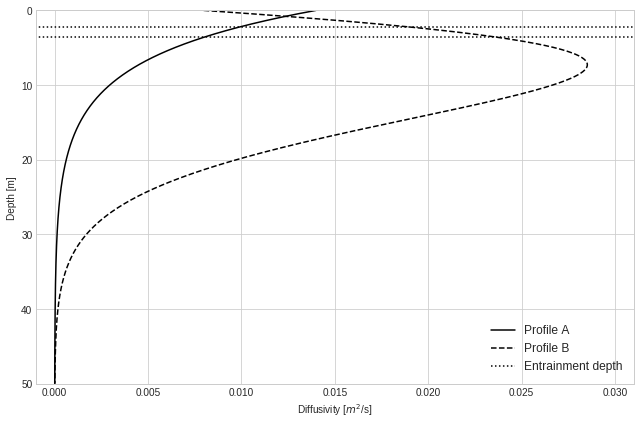

In [5]:
zc = np.linspace(0, 50, 1000)

fig = plt.figure(figsize = (9, 6))

# Plot diffusivity profiles
plt.plot(K_A(zc, 0), zc, label = 'Profile A', c='k')
plt.plot(K_B(zc, 0), zc, label = 'Profile B', c='k', ls='--')

# Plot entrainment depth
plt.plot([-1, 1], [(1.5-0.35)*Hs, (1.5-0.35)*Hs], c='k', ls=':', label='Entrainment depth')
plt.plot([-1, 1], [(1.5+0.35)*Hs, (1.5+0.35)*Hs], c='k', ls=':')

plt.ylabel('Depth [m]')
plt.xlabel('Diffusivity [$m^2$/s]')

# Limit the horizontal axis
plt.xlim(-0.001, 0.031)
# Flip the vertical axis
plt.ylim(50, 0)

plt.legend(fontsize = 12)
plt.tight_layout()

# Model surfacing and entrainment

In [6]:
# Profile A, naïve scheme
CnA, HnA, ZnA, DnA = experiment(Z0, D0, Np, Tmax, dt, bins, K_A, windspeed, h0, mu, ift, rho, naivestep)
# Profile A, corrected scheme
CeA, HeA, ZeA, DeA = experiment(Z0, D0, Np, Tmax, dt, bins, K_A, windspeed, h0, mu, ift, rho, correctstep)

# Profile B, naïve scheme
CnB, HnB, ZnB, DnB = experiment(Z0, D0, Np, Tmax, dt, bins, K_B, windspeed, h0, mu, ift, rho, naivestep)
# Profile B, corrected scheme
CeB, HeB, ZeB, DeB = experiment(Z0, D0, Np, Tmax, dt, bins, K_B, windspeed, h0, mu, ift, rho, correctstep)

## Plot surfaced fraction as function of time

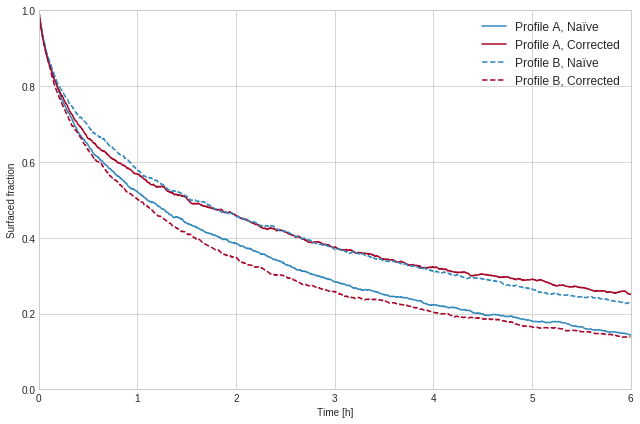

In [7]:
fig = plt.figure(figsize = (9,6))
times = np.arange(0, Tmax, dt)

# Plot surfaced as function of time in hours
plt.plot(times/3600, 1-CnA/Np, c = '#348ABD', label = 'Profile A, Naïve')
plt.plot(times/3600, 1-CeA/Np, c = '#A60628', label = 'Profile A, Corrected')
plt.plot(times/3600, 1-CnB/Np, '--', c = '#348ABD', label = 'Profile B, Naïve')
plt.plot(times/3600, 1-CeB/Np, '--', c = '#A60628', label = 'Profile B, Corrected')

plt.xlim(0, Tmax/3600)
plt.ylim(0, 1)

plt.ylabel('Surfaced fraction')
plt.xlabel('Time [h]')

plt.legend(fontsize = 12)
plt.tight_layout()
#plt.savefig('surfaced_timeseries.pdf')

## Plot (time-averaged) concentration profiles

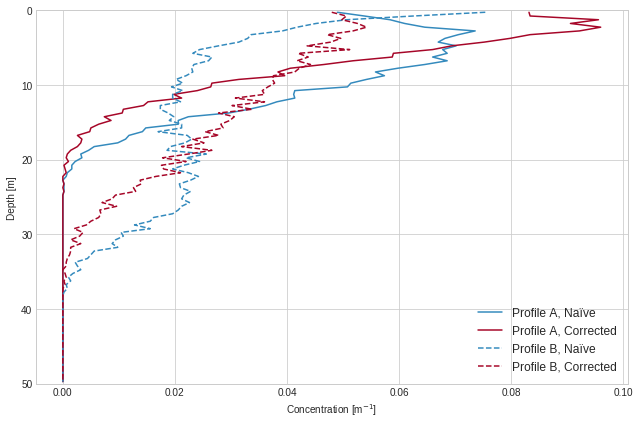

In [9]:
fig = plt.figure(figsize = (9,6))

# Calculate average over last 3600 seconds
# Change to Navg = 1 to get snapshot at last timestep
Navg = int(3600 / dt)
# Find midpoints of bins for plotting
dz = bins[1]-bins[0]
midpoints = bins[:-1] + dz/2

# Plot concentration profiles, normalised such that
# the integral of the profile is 1 if everything is submerged
plt.plot(np.mean(HnA[-Navg:,:], axis = 0)/(dz*Np), midpoints, c = '#348ABD', label = 'Profile A, Naïve')
plt.plot(np.mean(HeA[-Navg:,:], axis = 0)/(dz*Np), midpoints, c = '#A60628', label = 'Profile A, Corrected')
plt.plot(np.mean(HnB[-Navg:,:], axis = 0)/(dz*Np), midpoints, '--', c = '#348ABD', label = 'Profile B, Naïve')
plt.plot(np.mean(HeB[-Navg:,:], axis = 0)/(dz*Np), midpoints, '--', c = '#A60628', label = 'Profile B, Corrected')

# Flip the vertical axis
plt.ylim(50, 0)

plt.ylabel('Depth [m]')
plt.xlabel('Concentration [m$^{-1}$]')

plt.legend(fontsize = 12)
plt.tight_layout()
#plt.savefig('concentration_profiles.pdf')